# 1. Setup Paths

In [2]:
DATA_PATH = 'Tensorflow/data'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = DATA_PATH + '/annotations'
IMAGE_PATH = DATA_PATH + '/images'
MODEL_PATH = DATA_PATH + '/models' # putanja vlastitog treniranog modela
PRETRAINED_MODEL_PATH = DATA_PATH + '/pretrained-models' 
CHECKPOINT_PATH = MODEL_PATH + '/ssd_mobnet_znakovi'
CONFIG_FILE = MODEL_PATH + '/ssd_mobnet_znakovi/pipeline.config'

# 2. Create Label Map

In [3]:
labels = [{'name':'Cesta s prednošću prolaska', 'id':1}, {'name':'Divljač na cesti', 'id':2}, 
          {'name':'Obavezno zaustavljanje', 'id':3}, {'name':'Ograničenje brzine 40', 'id':4}, 
          {'name':'Ograničenje brzine 50', 'id':5}, {'name':'Ograničenje brzine 60', 'id':6}, 
          {'name':'Ograničenje brzine 70', 'id':7}, {'name':'Pješački prijelaz', 'id':8}, 
          {'name':'Približavanje pješačkom prijelazu', 'id':9}, {'name':'Zabrana pretjecanja', 'id':10}]


In [4]:
# output labels into a label map (.pbtxt format)
with open(ANNOTATION_PATH + "\label_map.pbtxt", 'w', encoding='utf-8') as file:
    for label in labels:
        file.write('item{\n')
        file.write('\tname:\'{}\'\n'.format(label['name']))
        file.write('\tid:{}\n'.format(label['id']))
        file.write('}\n')

# 3. Create TF record

In [5]:
!pip install tensorflow==2.10.0

In [5]:
!pip install tensorflow-object-detection-api

In [36]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/data/annotations/train.record
Successfully created the TFRecord file: Tensorflow/data/annotations/test.record


# 4. Download TF Pretrained Model from TF Model ZOO

In [7]:
import wget
wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
!move ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

  5% [...                                                                     ]  1056768 / 20515344

 20% [..............                                                          ]  4161536 / 20515344

 33% [........................                                                ]  6881280 / 20515344

 46% [.................................                                       ]  9437184 / 20515344

 61% [............................................                            ] 12689408 / 20515344

 78% [........................................................                ] 16097280 / 20515344

 94% [....................................................................    ] 19447808 / 20515344

100% [........................................................................] 20515344 / 20515344

        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


# 5. Update Model's "pipeline.config" For Transfer Learning

In [4]:
CUSTOM_MODEL_NAME = 'ssd_mobnet_znakovi'

In [5]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [6]:
config = config_util.get_configs_from_pipeline_file(CONFIG_FILE)

In [8]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_FILE, 'r') as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [9]:
pipeline_config.model.ssd.num_classes = 10
pipeline_config.train_config.batch_size = 6 # moze i vise zbog GPU
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH + '/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = 'detection'
pipeline_config.train_input_reader.label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [10]:
config_text = text_format.MessageToString(pipeline_config)
with tf.io.gfile.GFile(CONFIG_FILE, "wb") as f:
    f.write(config_text)

# 6. Train The Model

In [44]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={} --pipeline_config_path={} --num_train_steps=5000""".format(APIMODEL_PATH, CHECKPOINT_PATH, CONFIG_FILE))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/data/models/ssd_mobnet_znakovi --pipeline_config_path=Tensorflow/data/models/ssd_mobnet_znakovi/pipeline.config --num_train_steps=5000


In [ ]:
# otici u folder "zavrsni" u terminal i izvesti gore ispisanu liniju

# 7. Evaluate The Model

In [17]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={} --pipeline_config_path={} --checkpoint_dir={}""".format(APIMODEL_PATH, CHECKPOINT_PATH, CONFIG_FILE, CHECKPOINT_PATH))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/data/models/ssd_mobnet_znakovi --pipeline_config_path=Tensorflow/data/models/ssd_mobnet_znakovi/pipeline.config --checkpoint_dir=Tensorflow/data/models/ssd_mobnet_znakovi


In [ ]:
# otici u folder "zavrsni" u terminal i izvesti gore ispisanu liniju

# 8. Load Train Model From Checkpoint

In [7]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [8]:
# Loading pipeline config and building a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_FILE)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restoring from checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-6')).expect_partial()

In [9]:
@tf.function
def detect(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect From An Image

In [10]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH + '/label_map.pbtxt')

In [43]:
IMG_PATH = os.path.join(IMAGE_PATH, 'test', 'znak088.jpg')
# 088 - divljac
# 177, 185 - stop
# 193 - ogranicenje 40 
# 267 - ogranicenje 50
# 341 - ogranicenje 60 
# 406 - pjesacki
# 476 - priblizavanje pjesackom
# 580 - zabrana pretjecanja

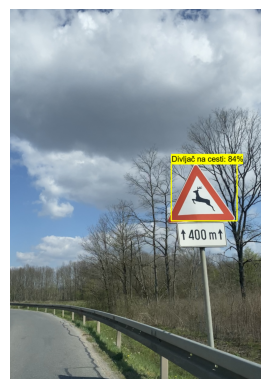

In [44]:
img = cv2.imread(IMG_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
             for key, value in detections.items()}
detections['num_detections']=num_detections

# detections_classes should be ints
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes']+label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=.7,
    agnostic_mode=False
)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 10. Detect in Real-Time

In [46]:
def detect_in_video(cap, width, height):
    while True:
        ret, frame = cap.read()
        image_np = np.array(frame)
    
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect(input_tensor)
    
        num_detections = int(detections.pop('num_detections'))
        detections = {key:value[0, :num_detections].numpy() for key, value in detections.items()}
        detections['num_detections'] = num_detections
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
        label_id_offset = 1
        image_np_with_detections = image_np.copy()
    
        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False
        )
    
        cv2.imshow('Detekcija Prometnih Znakova', cv2.resize(image_np_with_detections, (width, height)))
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break        

In [47]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
detect_in_video(cap, width, height)

# 11. Detect From Video

In [48]:
cap = cv2.VideoCapture("./video.mov")
width = 800
height = 800
detect_in_video(cap, width, height)